# Test 1 
### Fit a Sérsic source with a fixed parametric lens (SIE + shear)
as discussed in the meeting @Cubotron on 02.06.2021

__last update__: 12/07/21

In [2]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import numpy as np
from scipy.optimize import minimize
from copy import deepcopy

# Basic JAX
import jax
from jax import lax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import corner

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Inference.parameters import Parameters
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [4]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [5]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [6]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

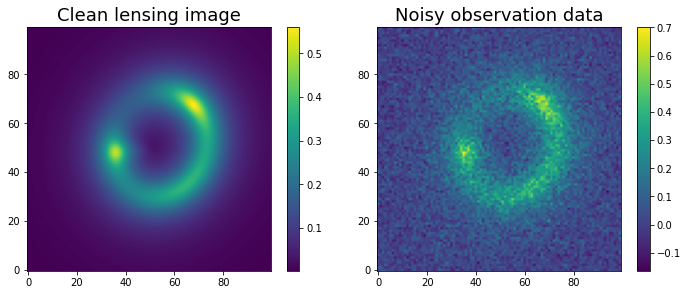

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [8]:
# (Don't trust this the first time you run it.)
%timeit image_model.image(kwargs_lens_mass, kwargs_source_light, kwargs_lens_light, kwargs_ps={})

108 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Source fitting

### Parameter class

In [10]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'amp': 1.0, 'R_sersic': 1.0, 'n_sersic': 2.5, 'center_x': 0.0, 'center_y': 0.0}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    #'kwargs_source': [{}],
    #'kwargs_source': [{'amp': ['uniform', 0, 20.], 'R_sersic': ['uniform', 0.5, 2.], 'n_sersic': ['uniform', 2., 5.], 'center_x': ['uniform', -0.8, 0.8], 'center_y': ['uniform', -0.8, 0.8]}],
    'kwargs_source': [{'amp': ['uniform', 6., 14.], 'R_sersic': ['uniform', 1., 1.4], 'n_sersic': ['uniform', 1., 2.], 'center_x': ['uniform', 0.2, 0.6], 'center_y': ['uniform', -0.05, 0.35]}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light}
p_true = parameters.kwargs2args(kwargs_true)
param_names = parameters.names
print("truths:", p_true, param_names)

print(parameters.prior_types)
print(parameters.bounds)
print(parameters.log_prior(parameters.initial_values()))

truths: [10.    1.2   1.5   0.4   0.15] ['amp', 'R_sersic', 'n_sersic', 'center_x', 'center_y']
['uniform', 'uniform', 'uniform', 'uniform', 'uniform']
(array([ 6.  ,  1.  ,  1.  ,  0.2 , -0.05]), array([14.  ,  1.4 ,  2.  ,  0.6 ,  0.35]))
-30000000000.0


### Loss function

In [9]:
def create_loss_func(data, model, param, noise_var=None):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    noise_var : 2D array, optional
        Noise variance per pixel assuming independence, i.e.
        a diagonal covariance matrix.
    
    """
    if noise_var is None:
        noise_var = jnp.ones_like(data)
    assert noise_var.shape == data.shape, "Invalid noise variance map"
    
    def loss_func(kwargs):
        # Compute reconstruction with these parameters
        rec = model.image(**kwargs)
        
        # negative log-likelihood
        #loss = 0.5 * jnp.mean((data - rec)**2 / noise_var)
        loss = 0.5 * jnp.sum((data - rec)**2 / noise_var)
        
        # negative log-prior
        #loss -= param.log_prior(param.kwargs2args(kwargs))
        
        # Other regularisations
        # loss += ...
        
        return loss
    
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = jnp.abs(image) / exp_time + gaussian.var()
loss = create_loss_func(data, image_model, parameters, noise_var=noise_var)
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters

In [10]:
loss(kwargs_true)

DeviceArray(5003.71869379, dtype=float64)

In [11]:
grad_loss(kwargs_true)

{'kwargs_lens': [{'center_x': DeviceArray(-234.03339258, dtype=float64),
   'center_y': DeviceArray(174.25376047, dtype=float64),
   'e1': DeviceArray(-94.98240576, dtype=float64),
   'e2': DeviceArray(-5.12958873, dtype=float64),
   'theta_E': DeviceArray(394.6289091, dtype=float64)},
  {'dec_0': DeviceArray(-8.83913942, dtype=float64),
   'gamma1': DeviceArray(221.95151774, dtype=float64),
   'gamma2': DeviceArray(115.389488, dtype=float64),
   'ra_0': DeviceArray(11.04247556, dtype=float64)}],
 'kwargs_source': [{'R_sersic': DeviceArray(16.04616922, dtype=float64),
   'amp': DeviceArray(3.42359855, dtype=float64),
   'center_x': DeviceArray(375.59893818, dtype=float64),
   'center_y': DeviceArray(-242.88287256, dtype=float64),
   'n_sersic': DeviceArray(26.47671711, dtype=float64)}]}

### Minimize the loss function over source parameters using scipy

In [12]:
# Optimise !
optimizer = Optimizer(loss, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

Runtime: 3.3220062255859375


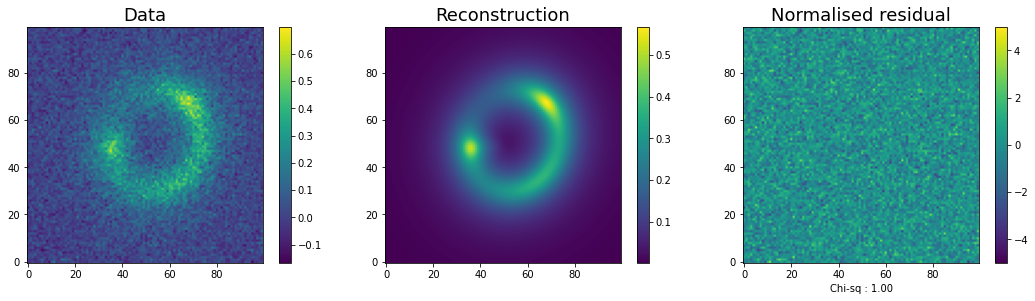

In [13]:
def plot_image_model(kwargs):
    rec = image_model.image(**kwargs)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.sum((data - rec)**2 / noise_var) / data.size
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [14]:
def print_errors(kwargs):
    print("Error")
    print("-----")
    for key, value in kwargs_source_light[0].items():
        fit = kwargs['kwargs_source'][0][key]
        error = 100 * abs(value - fit) / value
        spaces = " " * 6 if len(key) < 5 else " "
        print(key + ":" + spaces + f"{error:.2f} %")
        
print_errors(kwargs_final)

Error
-----
amp:      2.19 %
R_sersic: 2.34 %
n_sersic: 0.38 %
center_x: 0.68 %
center_y: 4.33 %


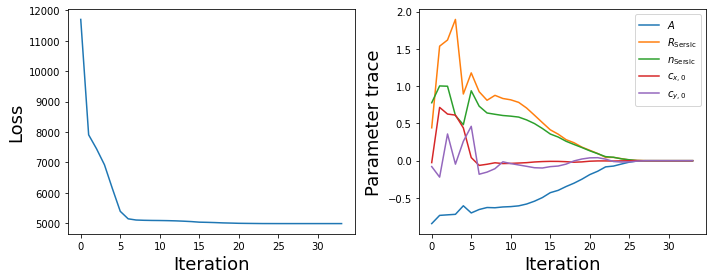

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Fisher matrix

Using approximated inverse Hessian


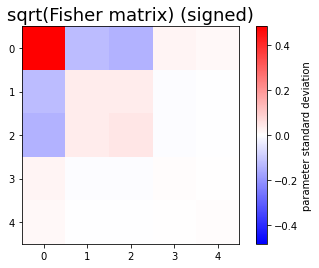

In [16]:
if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
else:
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.colorbar(label="parameter standard deviation")
plt.show()

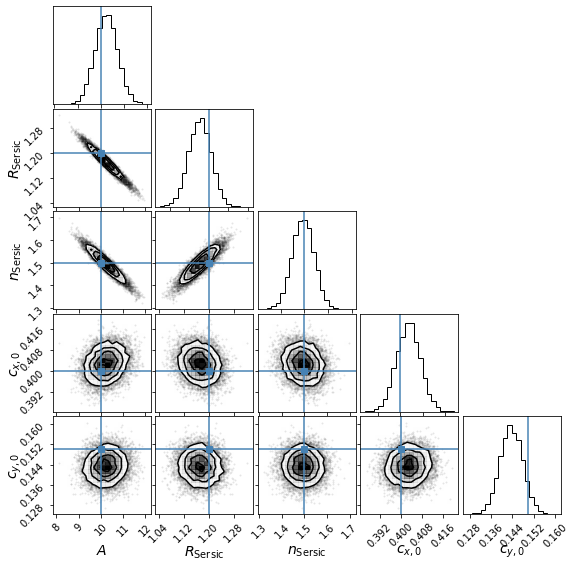

In [17]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(best_fit, fisher_matrix, ndraws=10000)

fig = plt.figure(figsize=(8, 8))
fig = corner.corner(samples_fisher, truths=p_true, show_titles=False, labels=parameters.symbols, 
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

In [18]:
raise

RuntimeError: No active exception to reraise

### Compare with PSO

## Posterior inference

### Hamiltonian Monte Carlo (HMC) with  `numpyro`

In [ ]:
sampler = Sampler(loss, parameters)

In [ ]:
samples, logL, extra_fields, runtime = sampler.hmc(num_warmup=100, num_samples=2000, 
                                                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples.shape}")

In [ ]:
#print(extra_fields.keys())

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes[0]
ax.set_title("energy terms", fontsize=FS)
ax.plot(extra_fields['potential_energy'], label="potential")
ax.plot(extra_fields['energy'], label="potential + kinetic")
ax.legend()
ax = axes[1]
ax.set_title("acceptance probability", fontsize=FS)
ax.plot(extra_fields['accept_prob'])
plt.show()

In [ ]:
kwargs_posterior = parameters.MAP_values(as_kwargs=True)
print(kwargs_posterior, loss(kwargs_posterior))

plot_image_model(kwargs_posterior)

In [ ]:
fig = corner.corner(samples, truths=p_true, show_titles=True, 
                    labels=parameters.symbols, 
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

In [ ]:
# compare uncertainties with Fisher information estimates
mcmc_std = samples.std(axis=0)
fisher_std = np.diag(np.sqrt(fisher_matrix))
print("MCMC uncertainties:", mcmc_std)
print("Fisher estimates (lower bound):", fisher_std)

### Compare with usual MCMC with `emcee`

In [ ]:
# decide on some scatter to initialize emcee walkers
kwargs_std = {
    'kwargs_source': [{'amp': 0.1, 'R_sersic': 0.1, 'n_sersic': 0.1, 'center_x': 0.1, 'center_y': 0.1}], 
    'kwargs_lens': [{}, {}]
}
init_stds = parameters.kwargs2args(kwargs_std)

# define a non-jitted log-likelihood function
def log_likelihood_nojit(args):
    # Compute reconstruction with these parameters
    rec = image_model.image(**parameters.args2kwargs(args))
    # log-likelihood
    #log_l = - 0.5 * jnp.mean((data - rec)**2 / noise_var)
    log_l = - 0.5 * jnp.sum((data - rec)**2 / noise_var)
    # log-prior
    log_l += parameters.log_prior_nojit(args)
    return log_l

samples_mcmc, logL_mcmc, extra_fields_mcmc, runtime \
    = sampler.mcmc(log_likelihood_nojit, init_stds, 
                   walker_ratio=2, num_warmup=10, num_samples=10, 
                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_mcmc.shape}")

In [ ]:
fig = corner.corner(samples_mcmc, truths=p_true, show_titles=True, 
                    labels=parameters.symbols, 
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

## Nested sampling to estimate Bayesian evidence

__Warning__: be aware that runtime depends _highly_ on the parameter bounds! So make sure lower and upper limits are tight enough to improve efficiency of nested sampling algorithms.

In [22]:
lowers, uppers = parameters.bounds
print(lowers, uppers)

# below: `u` is the unit cube, `x` are parameters

@jax.jit
def prior_u(u):
    # prior transform from unit cube to parameter cube
    x = lowers + (uppers - lowers) * u
    return x

@jax.jit
def loglike_x(x):
    # log-likelihood to maximise
    return -loss(parameters.args2kwargs(x))

@jax.jit
def grad_x(x):
    # gradient of the log-likelihood wrt to x
    return jax.grad(loglike_x)(x)

@jax.jit
def grad_u(u):
    # gradient of the log-likelihood wrt to u (i.e. includes jacobian between u and x)
    return jax.grad(loglike_x)(u) * (uppers - lowers)

[ 6.    1.    1.    0.2  -0.05] [14.    1.4   2.    0.6   0.35]


### Using `dynesty` with Hamiltonian slice sampling

In [24]:
import dynesty

# option 1: provide the gradient of the log-l wrt x, and compute numerically the jacobian wrt to u
kwargs_hslice = dict(sample='hslice', gradient=grad_x, compute_jac=True)

# option 2: provide the gradient of the log-l directly wrt u
#kwargs_hslice = dict(sample='hslice', gradient=grad_u, compute_jac=False)

nested_sampler = dynesty.NestedSampler(loglike_x, prior_u, 
                                       parameters.num_parameters, 
                                       nlive=100, **kwargs_hslice)
nested_sampler.run_nested(dlogz=0.1) #maxiter=None, maxcall=None, dlogz=None, logl_max=inf

1690it [1:01:09,  2.17s/it, +100 | bound: 72 | nc: 1 | ncall: 924825 | eff(%):  0.194 | loglstar:   -inf < -5001.889 <    inf | logz: -5016.466 +/-  0.504 | dlogz:  0.001 >  0.109]


In [25]:
results = nested_sampler.results
results.summary()

Summary
nlive: 100
niter: 1690
ncall: 924825
eff(%):  0.194
logz: -5016.466 +/-  0.504


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


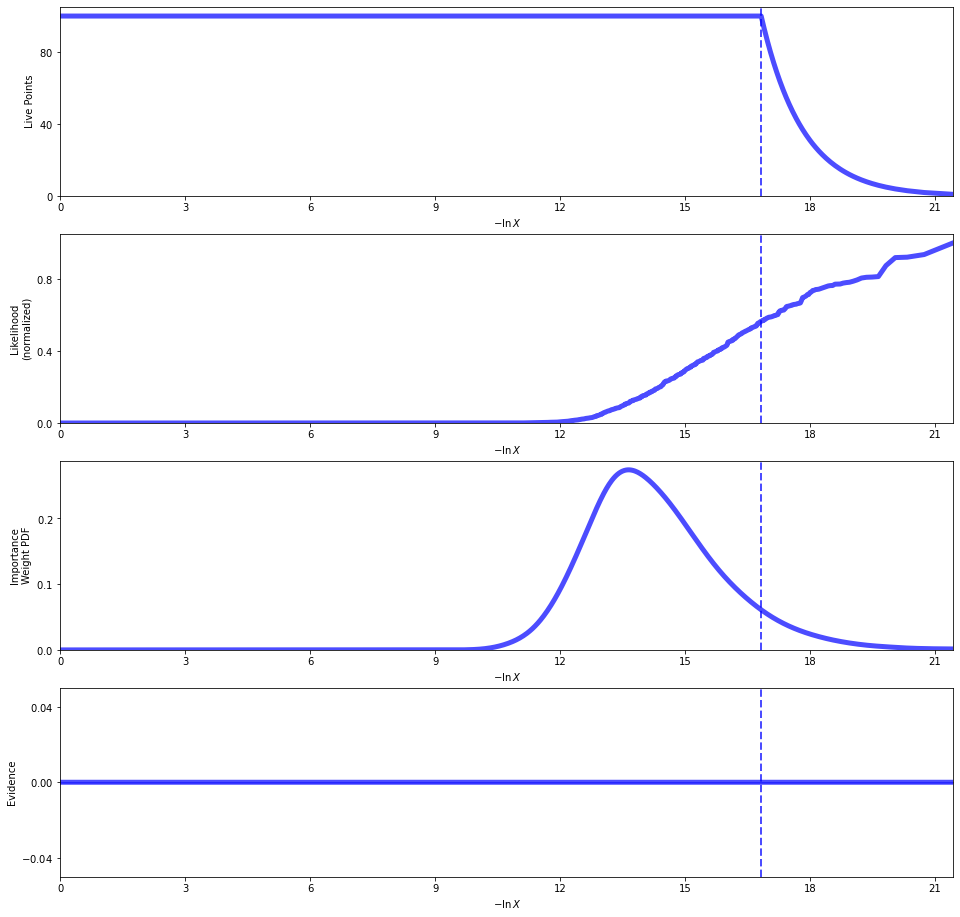

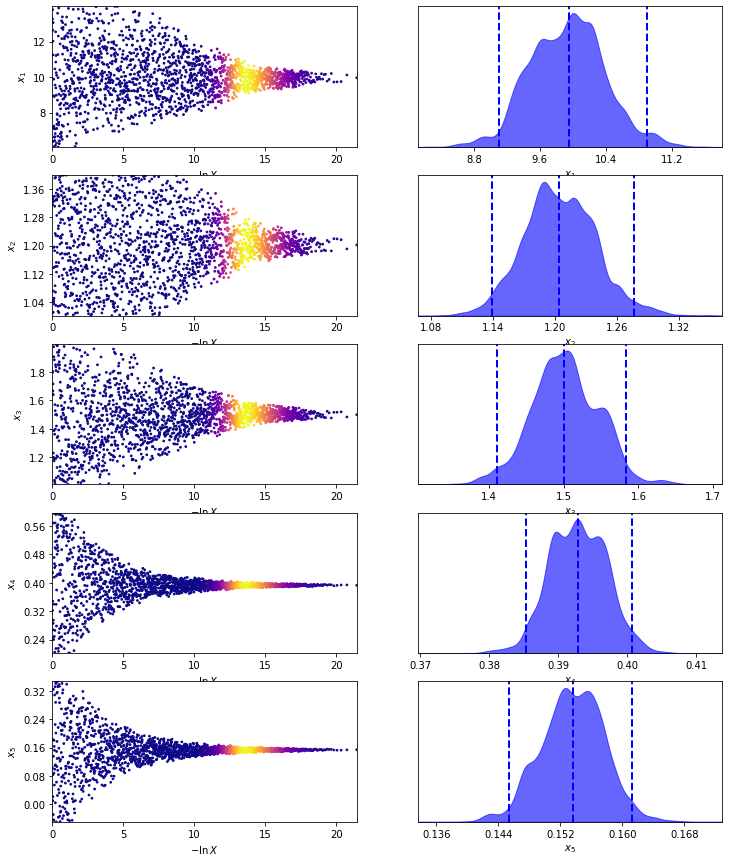

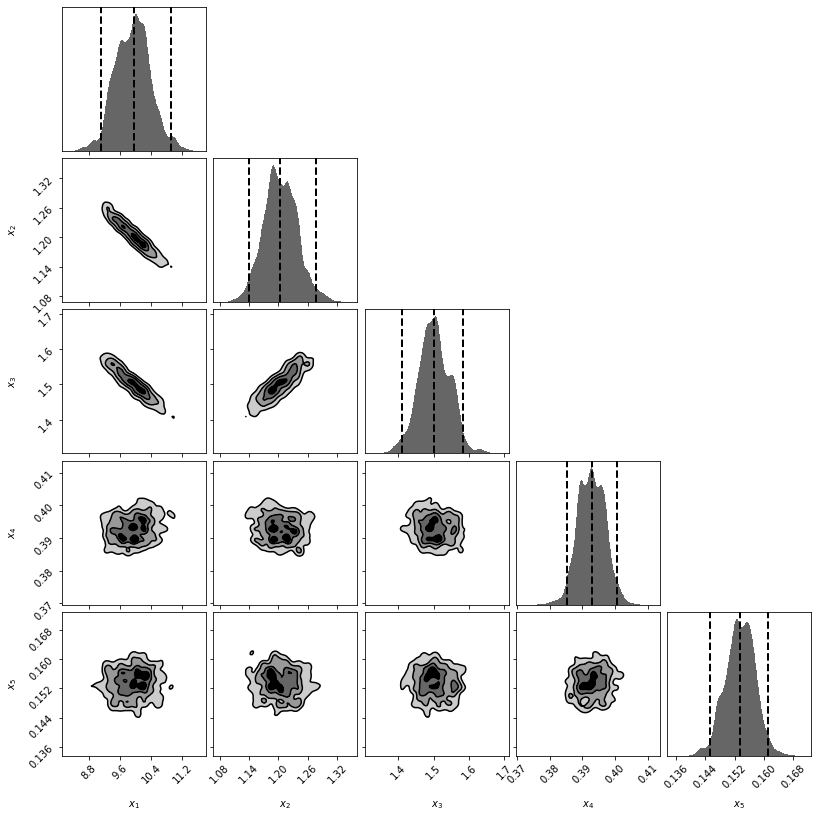

In [26]:
from dynesty import plotting as dyplot

results = nested_sampler.results

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

### Using `jaxns` for fast JAX-based backend

In [ ]:
from jaxns.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns import utils
from jaxns import plotting

@jax.jit
def loglike_x_kw(x, **kwargs):  # JAXNS needs **kwargs
    return -loss(parameters.args2kwargs(x))

prior_chain = PriorChain().push(UniformPrior('x', lowers, uppers))

ns = NestedSampler(loglike_x_kw, prior_chain, num_live_points=100)

jaxns_results = jax.jit(ns)(jax.random.PRNGKey(4525325), termination_frac=0.1)

--------
# likelihood evals: 279105
# samples: 2006
# likelihood evals / sample: 139.1
--------
logZ=-5017.45 +- 0.36
ESS=618
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 9.94 +- 0.51 | 9.32 / 9.91 / 10.65 | 9.52 | 10.01
x[1]: 1.204 +- 0.038 | 1.152 / 1.205 / 1.248 | 1.203 | 1.199
x[2]: 1.5 +- 0.05 | 1.433 / 1.502 / 1.562 | 1.47 | 1.491
x[3]: 0.3928 +- 0.0043 | 0.3877 / 0.3928 / 0.3981 | 0.3911 | 0.3929
x[4]: 0.1534 +- 0.0045 | 0.1481 / 0.1533 / 0.1595 | 0.1538 | 0.1531
--------


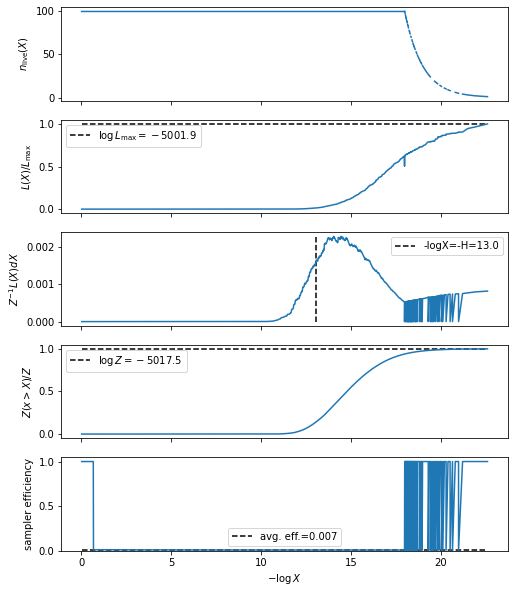

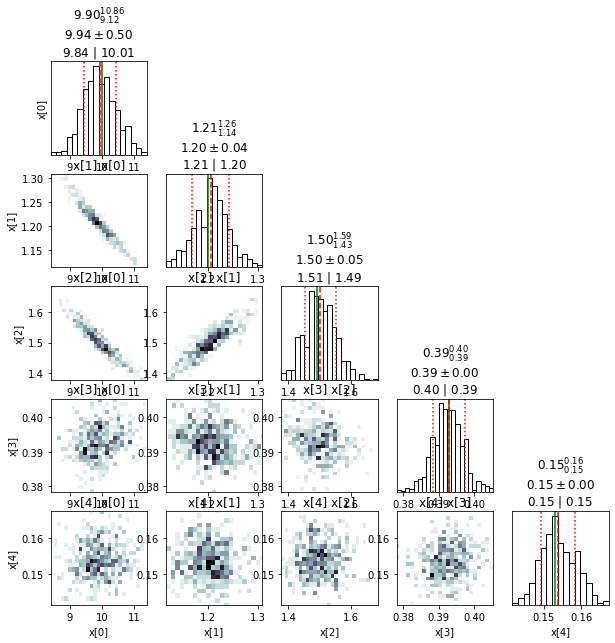

In [21]:
utils.summary(jaxns_results)

plotting.plot_diagnostics(jaxns_results)
plotting.plot_cornerplot(jaxns_results)